In [1]:
# basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# sklearn
# preprocessing, model selection and metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# visualize importances
import shap

pd.set_option('max_columns', None)
plt.style.use('ggplot')

In [2]:
from datetime import date
import gc

In [3]:
my_data = './data/'
fat_ljs_atual = pd.read_csv(my_data + 'faturamento_lojas_atuais.csv')
cen_exp = pd.read_csv(my_data + 'cenarios_expansao.csv')
ljs_atual = pd.read_csv(my_data + 'lojas_atuais.csv')

In [4]:
merge = fat_ljs_atual.merge(ljs_atual, on='cod_loja')

In [5]:
merge

,cod_loja,ano,mes,categoria,qtde,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,1,2016,1,CATEG_01,301.0,9164.86,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,CATEG_01,187.0,8175.55,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2016,3,CATEG_01,242.0,10521.67,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2016,4,CATEG_01,104.0,4560.91,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2016,5,CATEG_01,100.0,4263.30,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003090,3687,2017,9,CATEG_14,33.0,62.70,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003091,3687,2017,10,CATEG_14,184.0,349.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003092,3687,2017,11,CATEG_14,28.0,61.30,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mun_list = cen_exp.cod_municipio.unique()

In [7]:
###### cen_exp.head()
mun = mun_list[57]

fat_mun = merge[merge.cod_municipio == mun]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')
mensal

,cod_loja,cod_municipio,mes,ano,cod_ap,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,qtde,receita,datetime


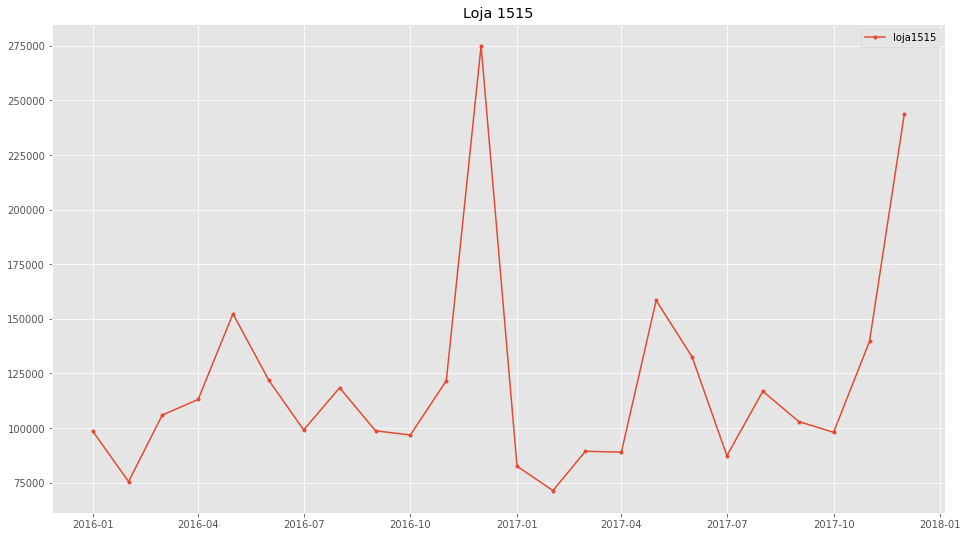

In [124]:
plt.figure(figsize=(16,9))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.title("Loja {}".format(cod))
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

In [9]:
cen_exp[cen_exp.cod_loja == 28]

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
4,28,3550308005058,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,44.31,FEATURE_05_VALUE_03,8,0.190102,0.17914,5593.905463,2.815883,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN


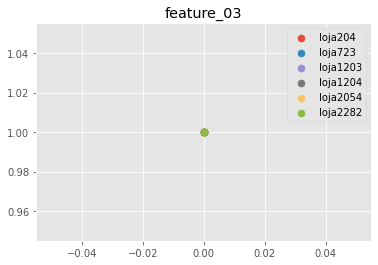

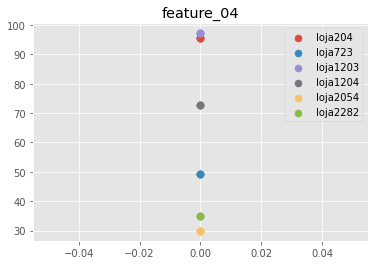

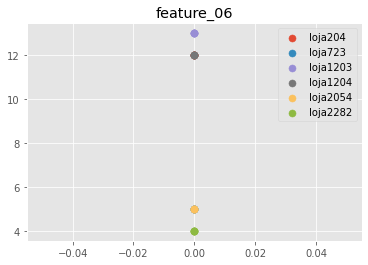

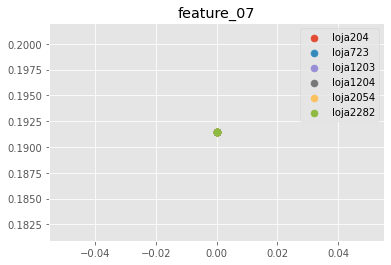

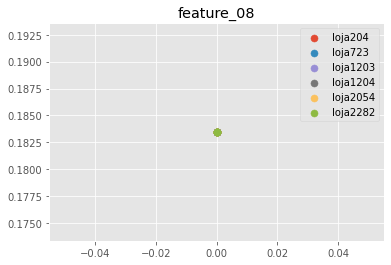

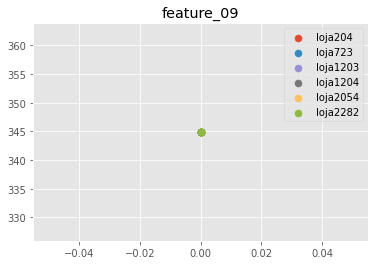

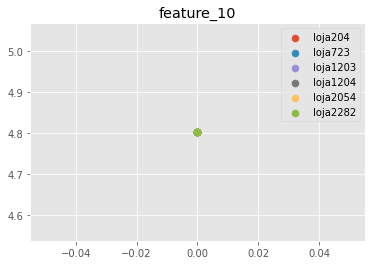

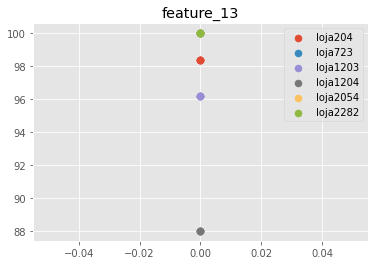

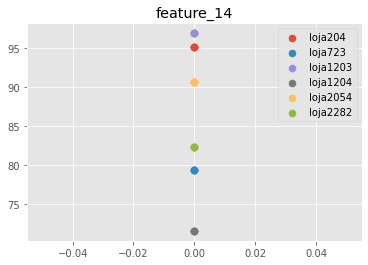

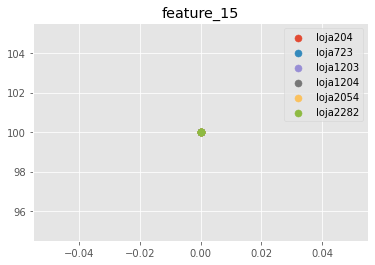

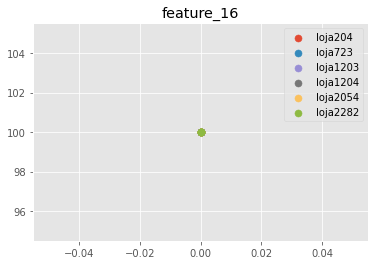

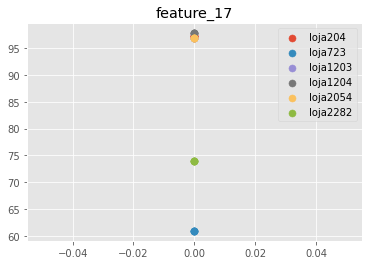

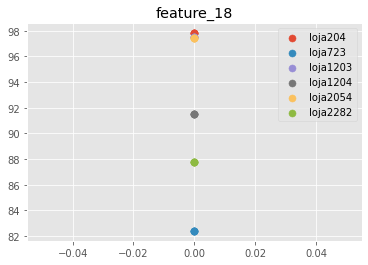

In [88]:
lojas_feats = mensal.groupby(['cod_loja'] + feats, as_index=False).sum()[['cod_loja'] + feats]
for feat in feats:
    for cod in mensal.cod_loja.unique()[:]:
        loj_mensal = mensal[mensal.cod_loja == cod]
        plt.scatter([0,0,0,0,0], loj_mensal[feat][:5], label='loja' + str(cod), marker=".", s=200, vmin=-1, vmax=1)
        plt.legend()
    plt.title(feat)
    plt.show()


In [32]:
feats[8:10]

['feature_14', 'feature_15']

In [35]:
ljs_atual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cod_loja       3130 non-null   int64  
 1   cod_ap         3130 non-null   int64  
 2   cod_municipio  3130 non-null   int64  
 3   feature_01     1171 non-null   object 
 4   feature_02     3130 non-null   object 
 5   feature_03     3130 non-null   bool   
 6   feature_04     3130 non-null   float64
 7   feature_05     3130 non-null   object 
 8   feature_06     3130 non-null   int64  
 9   feature_07     3130 non-null   float64
 10  feature_08     3130 non-null   float64
 11  feature_09     3130 non-null   float64
 12  feature_10     3130 non-null   float64
 13  feature_11     245 non-null    object 
 14  feature_12     245 non-null    object 
 15  feature_13     874 non-null    float64
 16  feature_14     874 non-null    float64
 17  feature_15     874 non-null    float64
 18  feature_

## Tentativa por mesorregião

In [5]:
ibge = pd.read_excel(my_data + 'ibge.xls')

In [6]:
ibge.head()
mun_meso = ibge[['Mesorregião Geográfica', 'UF', 'Código Município Completo']]
mun_meso.rename(columns={'Mesorregião Geográfica': 'meso', 'Código Município Completo': 'cod_municipio'}, inplace=True)

mun_meso['uf_meso'] = (mun_meso.UF.astype(str) + mun_meso.meso.astype(str)).astype(int)
mun_meso.drop(columns=['meso', 'UF'], inplace=True)

me_merge = merge.merge(mun_meso, on='cod_municipio', how='left')
me_merge_cex = cen_exp.merge(mun_meso, on='cod_municipio', how='left')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
mesos = me_merge_cex.uf_meso.unique()
idx = 50

fat_mun = me_merge[me_merge.uf_meso == mesos[idx]]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'uf_meso', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'uf_meso', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')

In [20]:
len(mesos)

114

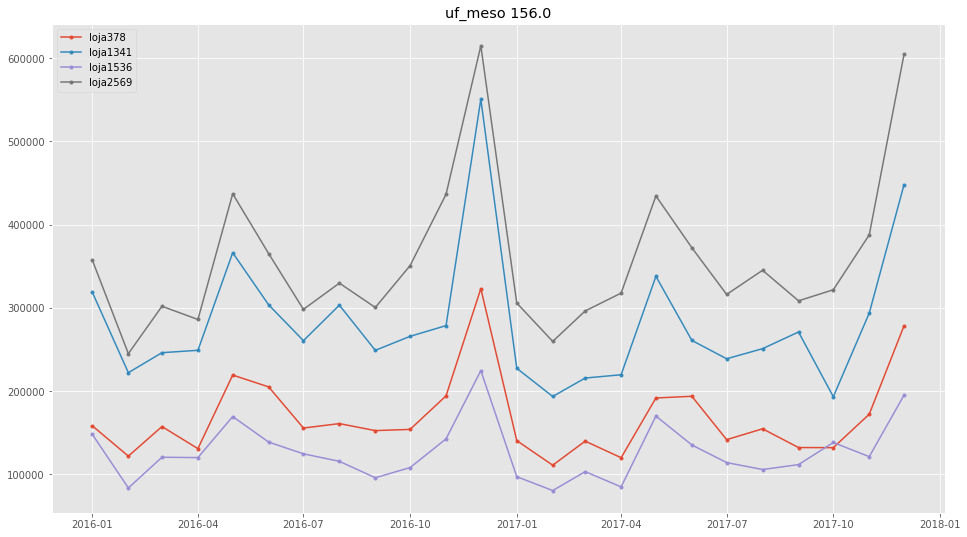

In [21]:
plt.figure(figsize=(16,9))
plt.title("uf_meso {}".format(mesos[idx]))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

## Mesorregiões do cen_exp não encontradas nas lojas atuais

In [101]:
print("TOTAL SIZE: " + str(len(mesos)))

cnt = 0
for meso in mesos:
    fm = me_merge[me_merge.uf_meso == meso]
    if fm.index.size == 0:
        print(meso)
        cnt += 1
        
print("\n" + str(cnt) + " " + str(cnt/len(mesos)))

TOTAL SIZE: 114
nan
121.0

2 0.017543859649122806


## Microrregiões

In [22]:
ibge.head()
mun_micro = ibge[['Microrregião Geográfica', 'UF', 'Código Município Completo']]
mun_micro.rename(columns={'Microrregião Geográfica': 'micro', 'Código Município Completo': 'cod_municipio'}, inplace=True)

mun_micro['uf_micro'] = (mun_micro.UF.astype(str) + mun_micro.micro.astype(str)).astype(int)
mun_micro.drop(columns=['micro', 'UF'], inplace=True)

mi_merge = merge.merge(mun_micro, on='cod_municipio', how='left')
mi_merge_cex = cen_exp.merge(mun_micro, on='cod_municipio', how='left')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
rec_med_mensal = mi_merge.groupby(['mes', 'uf_micro'], as_index=False).mean()[['uf_micro', 'mes', 'receita']]
mi_merge_cex = mi_merge_cex.merge(rec_med_mensal, on='uf_micro')

In [73]:
mi_merge_cex[['cod_loja', 'mes', 'receita']].to_csv(my_data + "media_receitas_microrregiao.csv")

,cod_loja,mes,receita
0,10,1,5046.407949
1,10,2,3836.906119
2,10,3,4641.766590
3,10,4,4612.981296
4,10,5,6763.523319
...,...,...,...
6103,3608,8,11589.171222
6104,3608,9,10928.387463
6105,3608,10,11088.492296
6106,3608,11,13243.924976


In [89]:
a = mi_merge_cex.cod_loja.unique().tolist()
b = cen_exp.cod_loja.unique().tolist()

[]

## Microrregiões do cen_exp não encontradas nas lojas atuais

In [27]:
print("TOTAL SIZE: " + str(len(micros)))

cnt = 0
for micro in micros:
    fm = mi_merge[mi_merge.uf_micro == micro]
    if fm.index.size == 0:
        print(micro)
        cnt += 1
        
print("\n" + str(cnt) + " " + str(cnt/len(micros)))

TOTAL SIZE: 236
3135.0
433.0
4211.0
225.0
nan
4334.0
121.0
2114.0
4132.0
4128.0
2514.0
2311.0
2330.0

13 0.05508474576271186


In [35]:
micros = mi_merge_cex.uf_micro.unique()
print(micros)
idx = 72

fat_mun = mi_merge[mi_merge.uf_micro == micros[idx]]

[2928. 2929. 2920.  298. 3561. 3548. 3518. 3512. 2110. 2324. 3118. 3156.
 3153. 3142. 5212. 5217.  176.  426. 4139. 4111.  415. 3130. 4122.  329.
 3164. 3514.  316.  355. 3539.  513. 4326.  241. 2411. 2925. 3315. 4125.
  437. 3135. 3532. 3149.  174. 4212.  296.  219. 2412.  527.  226.  433.
 1510. 3313. 3123.  279.  265. 3212. 2911. 4121. 3547. 5210. 4137. 3162.
 4134. 2922. 2616.  268. 1517. 5113. 4211. 2712. 3318. 3127. 4324. 5214.
 3546. 5114. 3150. 3151. 4325. 4124.  313.  295. 3165. 3515. 2326.  505.
 3117. 3131.  526. 3143. 3560.  218.  225.   nan  336. 2932. 4219. 3526.
 4316. 2916. 5117. 3563.  424. 3555. 2418. 2416. 3558.  178. 2914.  273.
 2617. 4321. 4310. 3562. 3133. 2613. 3559. 1513. 3519. 2811. 3522. 4213.
 4216. 3124.  322.  325. 3154. 2610. 5111. 3310.  215. 4334.  419.  121.
 5215. 3119. 2114.  216. 3147. 2931. 3159.  291. 2912. 2120. 3528.  504.
 2921. 2919. 3556. 5216.  282. 1520. 5213. 3550. 3521.  137. 2414. 1516.
 4132. 2522.  326. 3531.  511.  507. 3125. 2513.  2

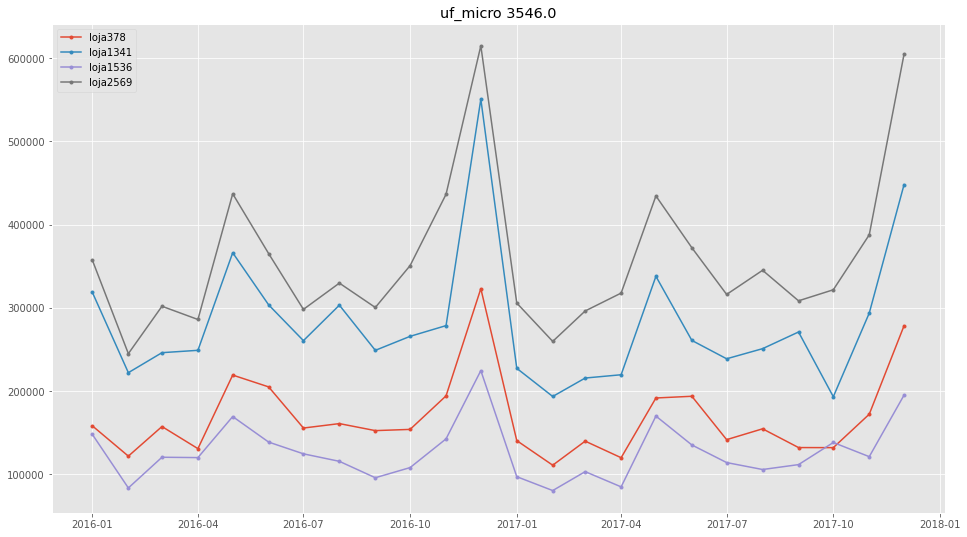

In [36]:
plt.figure(figsize=(16,9))
plt.title("uf_micro {}".format(micros[idx]))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

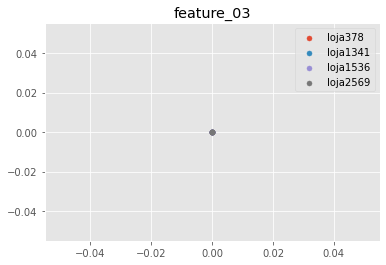

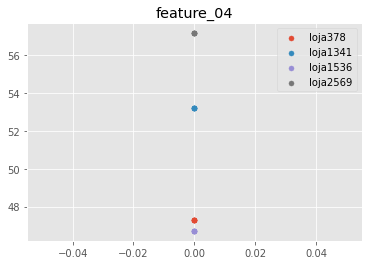

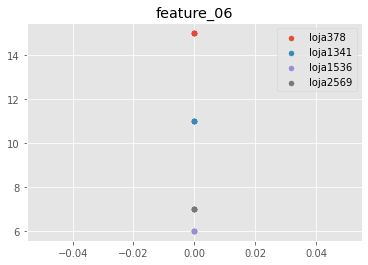

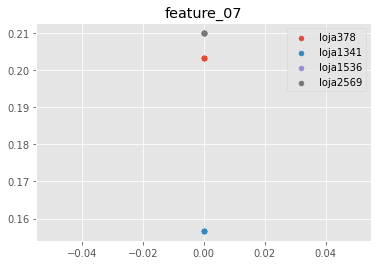

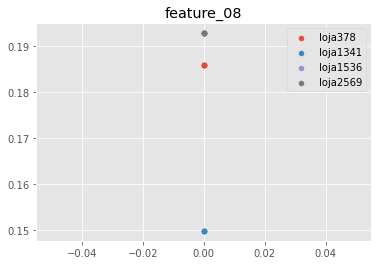

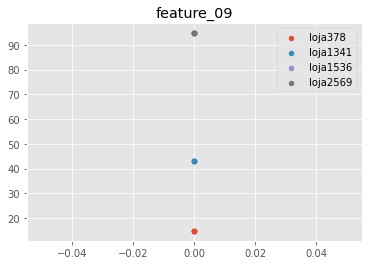

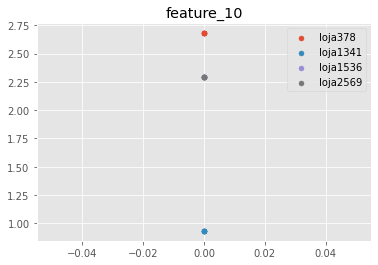

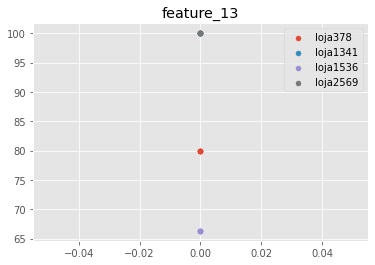

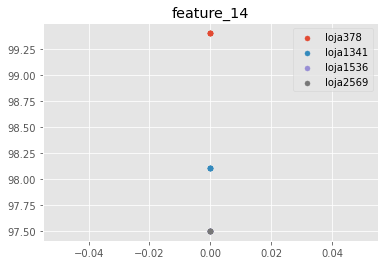

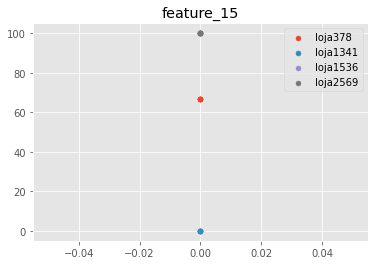

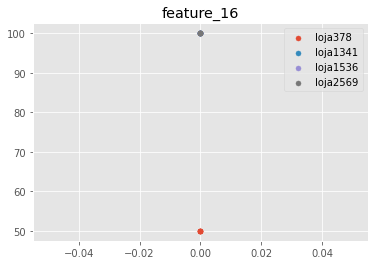

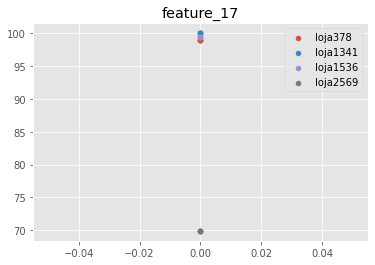

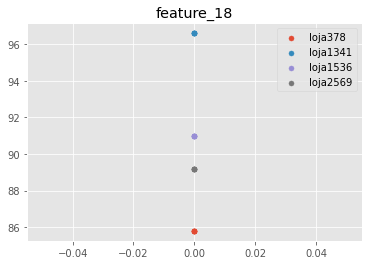

In [29]:
lojas_feats = mensal.groupby(['cod_loja'] + feats, as_index=False).sum()[['cod_loja'] + feats]
for feat in feats:
    for cod in mensal.cod_loja.unique()[:]:
        loj_mensal = mensal[mensal.cod_loja == cod]
        plt.scatter([0,0,0,0,0], loj_mensal[feat][:5], label='loja' + str(cod), marker=".", s=100, vmin=-1, vmax=1)
        plt.legend()
    plt.title(feat)
    plt.show()


## Criar csv associando loja ao UF

In [113]:
mun_uf = ibge[['UF', 'Código Município Completo']]
mun_uf.rename(columns={'Código Município Completo': 'cod_municipio'}, inplace=True)
merge_atuais = ljs_atual.merge(mun_uf, on='cod_municipio')[['cod_loja', 'UF']]
merge_atuais.to_csv("./data/uf_lojas_atuais.csv", index=False)

merge_exp = cen_exp.merge(mun_uf, on='cod_municipio')[['cod_loja', 'UF']]
merge_exp.to_csv("./data/uf_lojas_exp.csv", index=False)

In [131]:
me_merge.groupby(['cod_loja', 'uf_meso'], as_index=False).sum()[['cod_loja', 'uf_meso']].to_csv("./data/uf_meso_atuais.csv", index=False)
me_merge_cex.groupby(['cod_loja', 'uf_meso'], as_index=False).sum()[['cod_loja', 'uf_meso']].to_csv("./data/uf_meso_exp.csv", index=False)

In [130]:
me_merge_cex.cod_loja.value_counts()

2132    1
308     1
3389    1
315     1
3261    1
       ..
645     1
646     1
1674    1
652     1
1025    1
Name: cod_loja, Length: 553, dtype: int64

## Verificando base RESIC do IBGE

In [23]:
# depend: odfpy
resic = pd.read_excel(my_data + "indices_atracao.ods")

In [24]:
ias = ljs_atual.merge(resic, on='cod_municipio', how='left')
ias.corr()

,cod_loja,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,ia,ia_vestuario,ia_mov_eletro,cgt,empr_sede
cod_loja,1.000000,-0.120729,-0.120729,0.169759,-0.103481,-0.078999,-0.152981,-0.190864,0.075180,0.294726,0.041812,0.023209,0.018279,0.045464,0.057345,0.058542,0.143968,0.090985,0.189430,0.181612,0.053259
cod_ap,-0.120729,1.000000,1.000000,-0.051213,0.041909,-0.017965,0.153965,0.190962,0.019707,0.100010,0.024227,-0.029173,0.067989,-0.031997,-0.040715,-0.029677,0.003349,0.012761,-0.069456,0.130366,0.066021
cod_municipio,-0.120729,1.000000,1.000000,-0.051213,0.041909,-0.017965,0.153965,0.190962,0.019707,0.100010,0.024227,-0.029173,0.067989,-0.031997,-0.040715,-0.029677,0.003349,0.012761,-0.069456,0.130366,0.066021
feature_03,0.169759,-0.051213,-0.051213,1.000000,0.124035,0.145669,-0.133232,-0.157482,0.609696,-0.053604,0.050282,0.086332,0.042792,0.021468,0.080954,0.085361,0.683421,0.638187,0.647366,0.654977,0.585645
feature_04,-0.103481,0.041909,0.041909,0.124035,1.000000,0.448605,0.011591,-0.002947,0.135184,-0.193839,0.042179,0.021090,0.020047,0.009250,0.019252,0.017205,0.177520,0.158614,0.222288,0.263522,0.093066
feature_06,-0.078999,-0.017965,-0.017965,0.145669,0.448605,1.000000,-0.054785,-0.066604,0.132548,-0.224604,0.085621,0.036428,0.090765,0.059058,0.102287,0.095875,0.209757,0.173800,0.301256,0.297973,0.070602
feature_07,-0.152981,0.153965,0.153965,-0.133232,0.011591,-0.054785,1.000000,0.945458,-0.031834,0.091175,-0.040276,0.036939,0.030639,-0.053439,0.005402,0.017318,-0.161842,-0.079613,-0.297332,-0.198946,0.009112
feature_08,-0.190864,0.190962,0.190962,-0.157482,-0.002947,-0.066604,0.945458,1.000000,-0.075446,0.107026,-0.024476,0.051705,0.031239,-0.041437,-0.000487,0.024458,-0.209839,-0.121970,-0.331907,-0.243410,-0.032268
feature_09,0.075180,0.019707,0.019707,0.609696,0.135184,0.132548,-0.031834,-0.075446,1.000000,-0.150673,0.042876,0.123591,0.043670,0.061167,0.154515,0.149075,0.915698,0.947264,0.590675,0.719560,0.978802
feature_10,0.294726,0.100010,0.100010,-0.053604,-0.193839,-0.224604,0.091175,0.107026,-0.150673,1.000000,-0.027750,-0.038034,0.023856,-0.032390,-0.014420,-0.011449,-0.215016,-0.218712,-0.249153,-0.328342,-0.148950


## Distância da capital

In [26]:
cidades = pd.read_csv(my_data + "municipios.csv")

In [27]:
cidades

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31
2,5200100,Abadiânia,-16.19700,-48.7057,0,52
3,3100203,Abaeté,-19.15510,-45.4444,0,31
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15
...,...,...,...,...,...,...
5565,2933604,Xique-Xique,-10.82300,-42.7245,0,29
5566,2517407,Zabelê,-8.07901,-37.1057,0,25
5567,3557154,Zacarias,-21.05060,-50.0552,0,35
5568,2114007,Zé Doca,-3.27014,-45.6553,0,21


In [30]:
capitais = cidades[cidades.capital == 1][['codigo_ibge', 'codigo_uf', 'latitude', 'longitude']]
capitais

,codigo_ibge,codigo_uf,latitude,longitude
294,2800308,28,-10.909100,-37.0677
580,1501402,15,-1.455400,-48.4898
592,3106200,31,-19.910200,-43.9266
642,1400100,14,2.823840,-60.6753
755,5300108,53,-15.779500,-47.9297
972,5002704,50,-20.448600,-54.6295
1491,5103403,51,-15.601000,-56.0974
1508,4106902,41,-25.419500,-49.2646
1812,4205407,42,-27.594500,-48.5477
1831,2304400,23,-3.716640,-38.5423


In [32]:
cid_cap = cidades.merge(capitais, on='codigo_uf')
cid_cap

,codigo_ibge_x,nome,latitude_x,longitude_x,capital,codigo_uf,codigo_ibge_y,latitude_y,longitude_y
0,5200050,Abadia de Goiás,-16.7573,-49.4412,0,52,5208707,-16.6864,-49.2643
1,5200100,Abadiânia,-16.1970,-48.7057,0,52,5208707,-16.6864,-49.2643
2,5200134,Acreúna,-17.3960,-50.3749,0,52,5208707,-16.6864,-49.2643
3,5200159,Adelândia,-16.4127,-50.1657,0,52,5208707,-16.6864,-49.2643
4,5200175,Água Fria de Goiás,-14.9778,-47.7823,0,52,5208707,-16.6864,-49.2643
...,...,...,...,...,...,...,...,...,...
5565,3306107,Valença,-22.2445,-43.7129,0,33,3304557,-22.9129,-43.2003
5566,3306156,Varre-Sai,-20.9276,-41.8701,0,33,3304557,-22.9129,-43.2003
5567,3306206,Vassouras,-22.4059,-43.6686,0,33,3304557,-22.9129,-43.2003
5568,3306305,Volta Redonda,-22.5202,-44.0996,0,33,3304557,-22.9129,-43.2003


In [33]:
def calc_dist(row):
    earth_radius = 6371
    dlat = np.radians(row['latitude_x'] - row['latitude_y'])
    dlon = np.radians(row['longitude_x'] - row['longitude_y'])
    dlat1 = np.radians(row['latitude_x'])
    dlat2 = np.radians(row['latitude_y'])
    a = np.sin(dlat/2) ** 2 + np.sin(dlon/2) ** 2 * np.cos(dlat1) * np.cos(dlat2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return earth_radius * c

In [41]:
cid_cap['dist_km'] = cid_cap.apply(lambda x: calc_dist(x), axis=1)

In [46]:
ljs_dist = ljs_atual.merge(cid_cap, left_on='cod_municipio', right_on='codigo_ibge_x', how='left')
ljs_dist.corr()

,cod_loja,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,codigo_ibge_x,latitude_x,longitude_x,capital,codigo_uf,codigo_ibge_y,latitude_y,longitude_y,dist_km
cod_loja,1.000000,-0.120729,-0.120729,0.169759,-0.103481,-0.078999,-0.152981,-0.190864,0.075180,0.294726,0.041812,0.023209,0.018279,0.045464,0.057345,0.058542,-0.071444,0.032546,0.092591,0.151228,-0.071491,-0.070483,0.035584,0.075106,-0.121465
cod_ap,-0.120729,1.000000,1.000000,-0.051213,0.041909,-0.017965,0.153965,0.190962,0.019707,0.100010,0.024227,-0.029173,0.067989,-0.031997,-0.040715,-0.029677,1.000000,-0.700627,-0.351787,-0.067473,0.999803,0.999820,-0.714822,-0.356169,-0.030797
cod_municipio,-0.120729,1.000000,1.000000,-0.051213,0.041909,-0.017965,0.153965,0.190962,0.019707,0.100010,0.024227,-0.029173,0.067989,-0.031997,-0.040715,-0.029677,1.000000,-0.700627,-0.351787,-0.067473,0.999803,0.999820,-0.714822,-0.356169,-0.030797
feature_03,0.169759,-0.051213,-0.051213,1.000000,0.124035,0.145669,-0.133232,-0.157482,0.609696,-0.053604,0.050282,0.086332,0.042792,0.021468,0.080954,0.085361,0.000695,-0.101377,-0.041122,0.580010,-0.002053,0.001212,-0.093201,-0.088420,-0.372589
feature_04,-0.103481,0.041909,0.041909,0.124035,1.000000,0.448605,0.011591,-0.002947,0.135184,-0.193839,0.042179,0.021090,0.020047,0.009250,0.019252,0.017205,0.037827,-0.032863,-0.045827,0.177688,0.036267,0.037673,-0.034755,-0.071032,-0.119915
feature_06,-0.078999,-0.017965,-0.017965,0.145669,0.448605,1.000000,-0.054785,-0.066604,0.132548,-0.224604,0.085621,0.036428,0.090765,0.059058,0.102287,0.095875,-0.024483,0.041331,-0.048543,0.271050,-0.024083,-0.025220,0.048485,-0.084301,-0.201049
feature_07,-0.152981,0.153965,0.153965,-0.133232,0.011591,-0.054785,1.000000,0.945458,-0.031834,0.091175,-0.040276,0.036939,0.030639,-0.053439,0.005402,0.017318,0.204686,0.008609,-0.267670,-0.164918,0.203403,0.205863,-0.005292,-0.257592,0.241838
feature_08,-0.190864,0.190962,0.190962,-0.157482,-0.002947,-0.066604,0.945458,1.000000,-0.075446,0.107026,-0.024476,0.051705,0.031239,-0.041437,-0.000487,0.024458,0.243372,-0.060185,-0.326890,-0.212776,0.242328,0.244431,-0.074073,-0.308179,0.276655
feature_09,0.075180,0.019707,0.019707,0.609696,0.135184,0.132548,-0.031834,-0.075446,1.000000,-0.150673,0.042876,0.123591,0.043670,0.061167,0.154515,0.149075,0.048835,-0.165054,0.008130,0.678966,0.041527,0.048152,-0.149611,-0.043126,-0.368337
feature_10,0.294726,0.100010,0.100010,-0.053604,-0.193839,-0.224604,0.091175,0.107026,-0.150673,1.000000,-0.027750,-0.038034,0.023856,-0.032390,-0.014420,-0.011449,0.105109,-0.083860,-0.021537,-0.164927,0.105093,0.106711,-0.100554,0.026560,0.215182
